# Channel Estimation

This notebook steps through the procedures for channel estimation using OFDM transmission.

## Script Setup

In [13]:
from scipy.io import loadmat
from scipy import fft
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

First, load dataset.

In [14]:
dataset1 = loadmat("../datasets/dataset1.mat")

Then unpack constants.

In [15]:
K = int(dataset1['K'])
M = int(dataset1['M'])
N = int(dataset1['N'])

Unpack matrices.

In [16]:
pilotMatrix4N = dataset1['pilotMatrix4N']
receivedSignal4N = dataset1['receivedSignal4N']
transmitSignal = dataset1['transmitSignal'][:, 0]   # Transform from comumn vector to row vector

## Theoretical Background

The received samples are of the form $$z[n] = \sum_{k=0}^{M-1} h[k]x_{n-k} + w[n]$$ where $w[n]$ is a noise sample. This expression shows that $z[n]$ is a weighted sum of the current and the last $M-1$ symbols. Then, $z[1]$ depends on $x_1$ and $\{x_0, ..., x_{-(M-2)}\}$.

In this case, the signal is sampled in time, which means that it is periodic in frequency with a period of $1/T_s$.

Now, we don't want that the symbols from another block $\{x_0, ..., x_{-(M-2)}\}$ interfere with the samples from the current block. What we can do to fix this is turn $x_n$ into a periodic signal. When we do this, the signal in frequency becomes sampled, since it is equivalent to the coefficients of a fourier series.

When we do this, we say that *circular convolution* is happening, since the signal $x_n$ is periodic an can be thought of a circular signal. The sample $z[1]$ depends on all the samples that $h$ is able to cover, and $h$ actually grabs samples from the previous cycle.

The effect of this is ultimately that in frequency the signal turns into $H \cdot \bar{x}$, where $H$ and $\bar{x}$ are the size-$K$ DFT of $h$ and $x$ respectivelly. We can then encode the information symbols in $\bar{x}[n]$, which are affected independently by a channel tap $H[n]$.

Now we are ready to start processing the signal. First of all, the IFFT (Inverse Fast Fourier Transform) operation is scaled by a factor of $\sqrt{K}$ so that the noise remains with the same variance in both time and frequency domains. The FFT is scaled by $1/\sqrt{K}$. The channel FFT/IFFT operations are not scaled.

In [17]:
xf = transmitSignal
x = np.sqrt(K) * fft.ifft(xf)

Obtain the cyclic prefix and append to the signal.

In [18]:
cp = x[-(M-1):]
x_cp = np.concatenate((cp, x))

## Channel Estimation

We can estimate the channel using the following steps (from Modern Digital and Analog Communication Systems - Lathi) ![Channel Estimation](images/channel_estimation.png)

Now that we have the transmitted symbols `x_cp`we can compute the matrix $R[i, j]$ shown above.



In [19]:
R = np.zeros((M, M), dtype=complex)
for i in range(M):
    for j in range(M):
        R[i, j] = np.correlate(x_cp[M - 1 - j:M - 1 - j + K], x_cp[M - 1 - i:M - 1 - i + K])

R_inv = np.linalg.inv(R)

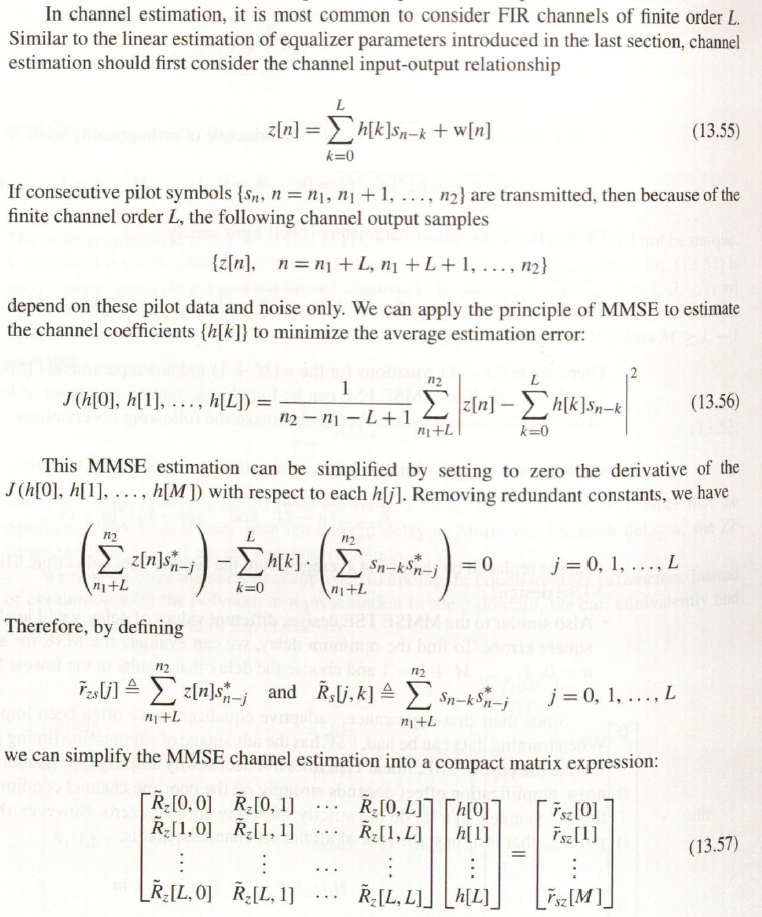

In [20]:
Image(filename='images\channel_estimation.png')